# A notebook to get you started with the Eulerian fields of the HYCOM model dataset

In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [17]:
import spectrum 
from clouddrift.sphere import coriolis_frequency

In [3]:
import boto3
import s3fs

ACCESS_KEY = ''
SECRET_ACCESS_KEY = ''


In [4]:

# Create a session using the user's access key and secret key
session = boto3.Session(
    aws_access_key_id= ACCESS_KEY,
    aws_secret_access_key= SECRET_ACCESS_KEY,
)

# Create an S3 client using the session
s3_client = session.client('s3')

# Now you can use the s3_client to interact with the S3 bucket
# For example, you can list all the objects in a bucket
response = s3_client.list_objects(Bucket='hycom-25-global')

# # Print the object keys
# for obj in response['Contents']:
#     print(obj['Key'])

In [5]:
bucket_name = 'hycom-25-global'
bucket = session.resource('s3').Bucket(bucket_name)

In [6]:
# List the elements at the root of the bucket
for obj in bucket.objects.filter(Delimiter='/'):
    print(obj.key)

README


In [7]:
# print the README file
# Get the file object
file_object = s3_client.get_object(Bucket=bucket_name, Key='README')
# Get the file content
file_content = file_object['Body'].read().decode()
# Print the file content
print(file_content)

This is a README file for the AWS S3 bucket "hycom-25-global" available at https://

This bucket contains two distinct but related datasets.

The first dataset in "hycom-25-global/eulerian/" consists of Eulerian (fixed grid) field variables which were generated from a 1-year simulation of the HYCOM model as described in Arbic et al. 2022. doi:10.1029/2022JC018551. The version of the dataset used for this paper can be accessed via the OSiRIS infrastructure of the University of Michigan-Ann Harbor and details for accessing OSiRIS can be obtained by contacting Brian K. Arbic (arbic@umich.edu).
The S3 bucket described here provides an alternative distribution of the same data (except model bottom velocity data) but organized differently as cloud-optimized zarr archives (https://zarr.readthedocs.io/en/stable/).

The second dataset in "hycom-25-global/lagrangian/" consists of Lagrangian particle trajectories advected in the velocity fields of the model at two depth (0 m and 15 m) and are not

In [8]:
# Create an S3 file system
s3 = s3fs.S3FileSystem(
    key= ACCESS_KEY,
    secret= SECRET_ACCESS_KEY
)


In [9]:
# select the first 30 days of data (720 hours)
step = 1
zarr_store_path = bucket_name+'/eulerian/hycom12-'+str(step)+'-rechunked-corr.zarr'
zarr_bathy_store_path = bucket_name+'/eulerian/hycom12_bathy.zarr'

# Create a Zarr store mapped object
store1 = s3fs.S3Map(root=zarr_store_path, s3=s3)
store2 = s3fs.S3Map(root=zarr_bathy_store_path, s3=s3)


In [10]:
print(f"The bathymetry file is {np.round(s3.du(zarr_bathy_store_path, total=True)/1024**2,0)} MB.")
print(f"The velocity file is {np.round(s3.du(zarr_store_path, total=True)/1024**3,0)} GB.")

The bathymetry file is 167.0 MB.
The velocity file is 327.0 GB.


In [11]:
# Lazily open the Zarr store with xarray; we saw above that the bathymetry file is modest but the velocity file is large.
# as a result we will load the bathymetry file first and then the velocity file lazily only
ds_bathy = xr.open_zarr(store2, consolidated="auto").load()
ds1 = xr.open_zarr(store1, consolidated="auto")

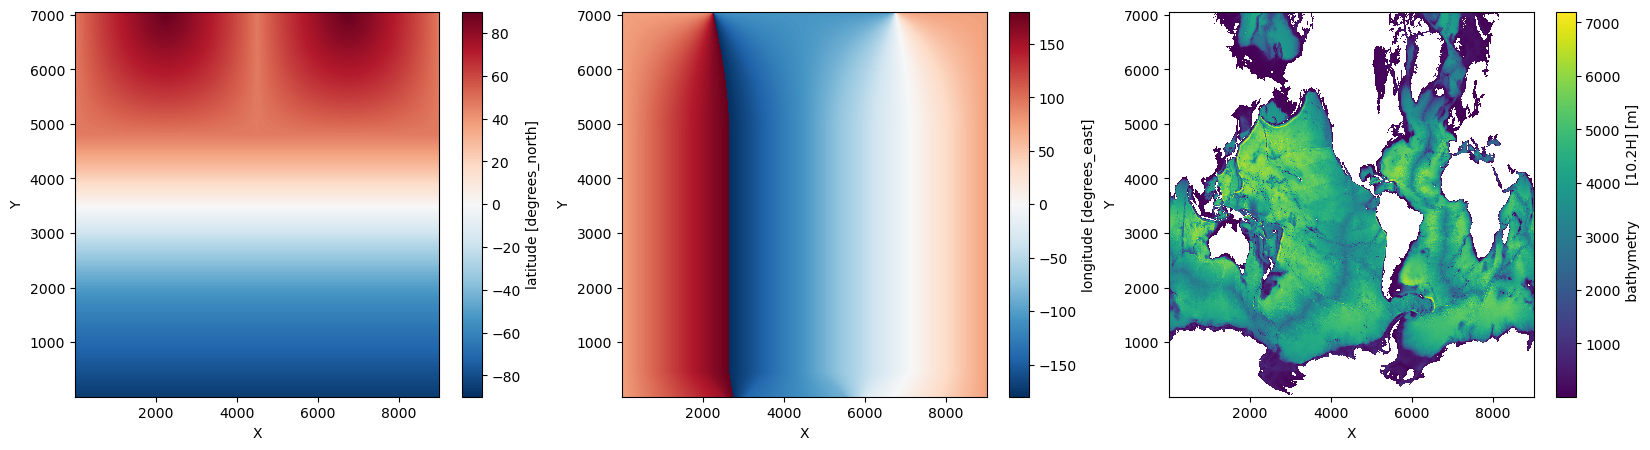

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# Plot Latitude
ds_bathy['Latitude'].plot(ax=axes[0])
# Plot Latitude
ds_bathy['Longitude'].plot(ax=axes[1])
# Plot Bathymetry
ds_bathy['bathymetry'].plot(ax=axes[2])

In [32]:
# Note that the data are chunked alomg the time dimension so the dataset is naturally suited
# for analyzing along the time dimension
# We select a point somewhere in the Southern Ocean
X1 = 2100
Y1 = 2200
print(f"Selecting point at X={X1}, Y={Y1} with latitude {ds1['Latitude'].isel(X=X1,Y=Y1).values} and longitude {ds1['Longitude'].isel(X=X1,Y=Y1).values} and depth {ds_bathy['bathymetry'].isel(X=X1,Y=Y1).values} m.")
# We can now load the velocity data at this point; extracting a dataarray
z = ds1["u"].isel(X=X1,Y=Y1)+1j*ds1["v"].isel(X=X1,Y=Y1).load()
z

Selecting point at X=2100, Y=2200 with latitude -45.15606689453125 and longitude 158.1600341796875 and depth 5254.92822265625 m.


<xarray.DataArray (time: 720, Depth: 2)>
dask.array<add, shape=(720, 2), dtype=complex64, chunksize=(720, 1), chunktype=numpy.ndarray>
Coordinates:
  * Depth      (Depth) float32 0.0 15.0
    Latitude   float32 -45.16
    Longitude  float32 158.2
    X          int32 2101
    Y          int32 2201
  * time       (time) datetime64[ns] 2014-01-01T01:00:00 ... 2014-01-31

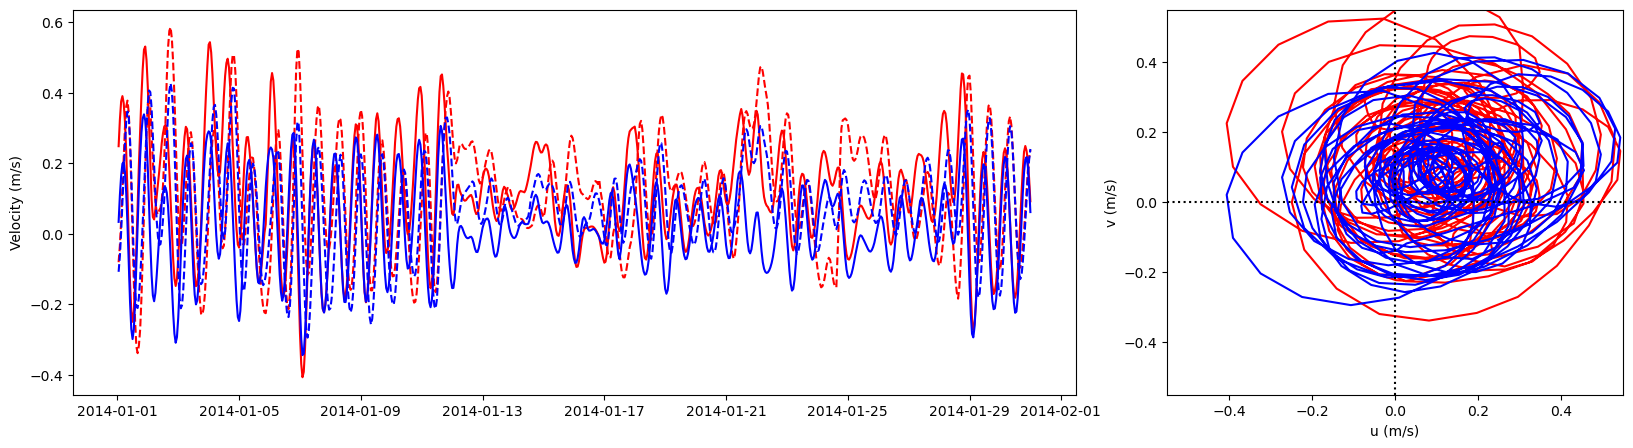

In [33]:
# Create a gridspec instance with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3)

# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create the first subplot in the first two columns of the grid
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(z["time"],z.real.isel(Depth=0),label="u, 0m",color="red",linestyle="-")
ax1.plot(z["time"],z.imag.isel(Depth=0),label="v, 0m",color="red",linestyle="--")
ax1.plot(z["time"],z.real.isel(Depth=1),label="u, 15m",color="blue",linestyle="-")
ax1.plot(z["time"],z.imag.isel(Depth=1),label="v, 15m",color="blue",linestyle="--")
ax1.set_ylabel("Velocity (m/s)")

# Create the second subplot in the third column of the grid
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(z.real.isel(Depth=0),z.imag.isel(Depth=0),label="0m",color="red")
ax2.plot(z.real.isel(Depth=0),z.imag.isel(Depth=1),label="0m",color="blue")
ax2.set_xlabel("u (m/s)")
ax2.set_ylabel("v (m/s)")
ax2.set_xlim(-0.55,0.55)
ax2.set_ylim(-0.55,0.55)
ax2.vlines(0,-0.55,0.55,linestyle=":",color="black")
ax2.hlines(0,-0.55,0.55,linestyle=":",color="black")
plt.show()

In [34]:
# create my function to get multitaper
def pmtm(x,dt=1,nw=3,method="unity"):
    """
    spectral multitaper estimate
    Args:
        x : vector input
        dt : sampling rate, default = 1
        nw : time-bandwidth product, default = 3
        k : number of tapers, default 2*nw-1
        method : multitaper method:  eigen, unity (default as it conserve the variance), or adapt
        
    Returns:
        f : Fourier frequencies
        s : spectral estimate
    """
    k = int(2*nw-1)
    f = np.fft.fftfreq(x.shape[0],dt) # define frequency scale/abscissa, dt is in units of days
    psi, eigs = spectrum.mtm.dpss(x.shape[0],NW=nw,k=k)
    if method=="adapt":
        Zk, weights, eigenvalues = spectrum.mtm.pmtm(x-np.mean(x),k,NFFT=np.size(x),v=psi,e=eigs,method=method)
        S = np.mean(np.abs(Zk*weights.T)**2, axis=0)*dt  
    else:
        Zk, weights, eigenvalues = spectrum.mtm.pmtm(x-np.mean(x),k,NFFT=np.size(x),v=psi,e=eigs,method=method)
        S = np.mean(np.abs(Zk*weights)**2, axis=0)*dt  

    return f,S

In [35]:
nw = 3
dt = 1/24
fz1,Sz1 = pmtm(x=z.isel(Depth=0).to_numpy(),dt=dt,nw=nw,method="unity")
fz2,Sz2 = pmtm(x=z.isel(Depth=1).to_numpy(),dt=dt,nw=nw,method="unity")


In [36]:
# Coriolis frequency in cycles per day
fcor = 86400*(1/(2*np.pi))*coriolis_frequency(ds1['Latitude'].isel(X=X1,Y=Y1).values)

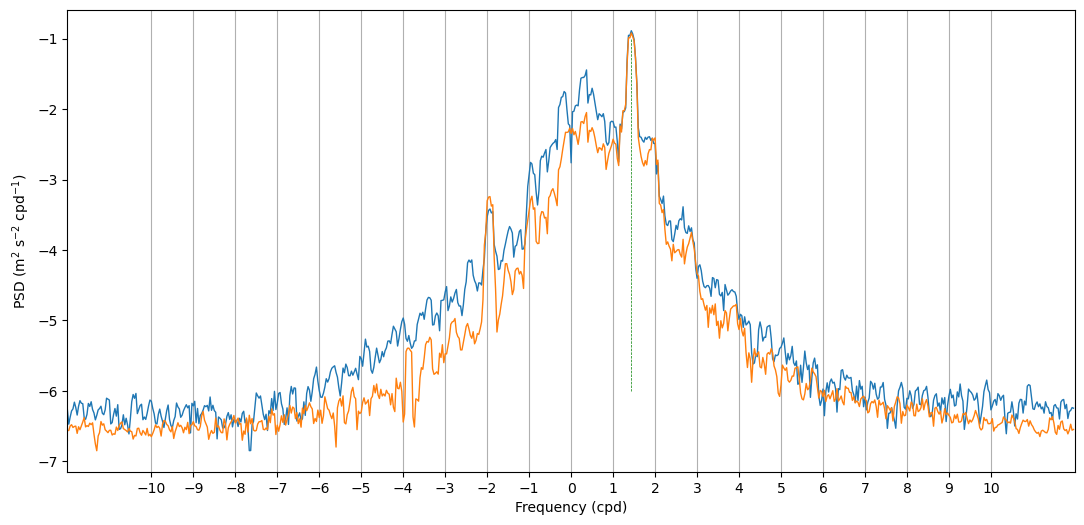

In [37]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
h1, = ax.plot(np.fft.fftshift(fz1),np.fft.fftshift(np.log10(Sz1)),scaley=True,linewidth=1)
h2, = ax.plot(np.fft.fftshift(fz2),np.fft.fftshift(np.log10(Sz2)),scaley=True,linewidth=1)

ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xlabel('Frequency (cpd)')
ax.set_xlim([-12,12])
ax.set_xticks(np.arange(-12,12,2))

#ax.vlines(tidefreq,ymin=-1,ymax=-6,linewidth=0.5,color='k',linestyle=':')
#ax.vlines(-tidefreq,ymin=-1,ymax=-6,linewidth=0.5,color='k',linestyle=':')
ax.vlines(-fcor,ymin=-1,ymax=-6,linewidth=0.5,color='g',linestyle='--')
#ax.set_ylim([-5,-2])
ax.grid(axis='x')    
ax.set_xticks(ticks=np.arange(-10,11,1));

In [26]:
coriolis_frequency?

Signature: coriolis_frequency(latitude: Union[float, numpy.ndarray]) -> Union[float, numpy.ndarray]
Docstring:
Return the Coriolis frequency or commonly known `f` parameter in geophysical fluid dynamics.

Parameters
----------
latitude : float or np.ndarray
    Latitude in degrees.

Returns
-------
f : float or np.ndarray
    Signed Coriolis frequency in radian per seconds.

Examples
--------
>>> f = coriolis_frequency(np.array([0, 45, 90]))
File:      /opt/homebrew/Caskroom/mambaforge/base/envs/hycom-25/lib/python3.11/site-packages/clouddrift/sphere.py
Type:      function